In [1]:
%matplotlib nbagg
import sys
import os
import time
sys.path.append("..")
# 自分のpath
os.chdir("/home/nakamura/HAI/main_server/hai")

import pymongo
from PIL import Image
from matplotlib import pylab as plt
from matplotlib.animation import ArtistAnimation
import matplotlib.animation as animation
import numpy as np
from bson.objectid import ObjectId
from sklearn.decomposition import PCA

from _app import app
from database import mongo

In [2]:
import controllers.utils as utils
import cv2
def visualize(col):
    im_path = app.config['RAW_IMG_DIR'] + col['filename']
    img = np.array(Image.open(im_path, 'r'))
    
    if len(col['keypoints']['people']) == 1:
        def draw_pts(pts, col):
            for x, y, c in utils.chunker(pts, 3):
                if c > 0.05:
                    cv2.circle(img, (int(x), int(y)), 3, col, -1)
      
        draw_pts(col["keypoints"]['people'][0]["pose_keypoints"], (0, 255, 0))
        draw_pts(col["keypoints"]['people'][0]["hand_left_keypoints"], (255, 0, 0))
        draw_pts(col["keypoints"]['people'][0]["hand_right_keypoints"], (255, 0, 0))

    return img

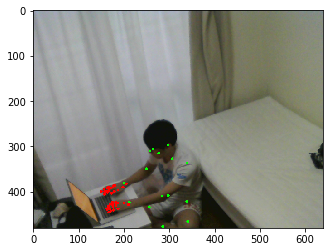

In [4]:
%matplotlib inline
images = mongo.images.find({'time': {"$gt": 1505547321.9468176}},
                        sort=[("_id", pymongo.ASCENDING)])
im = images.next()
plt.imshow(visualize(im))

<IPython.core.display.Javascript object>


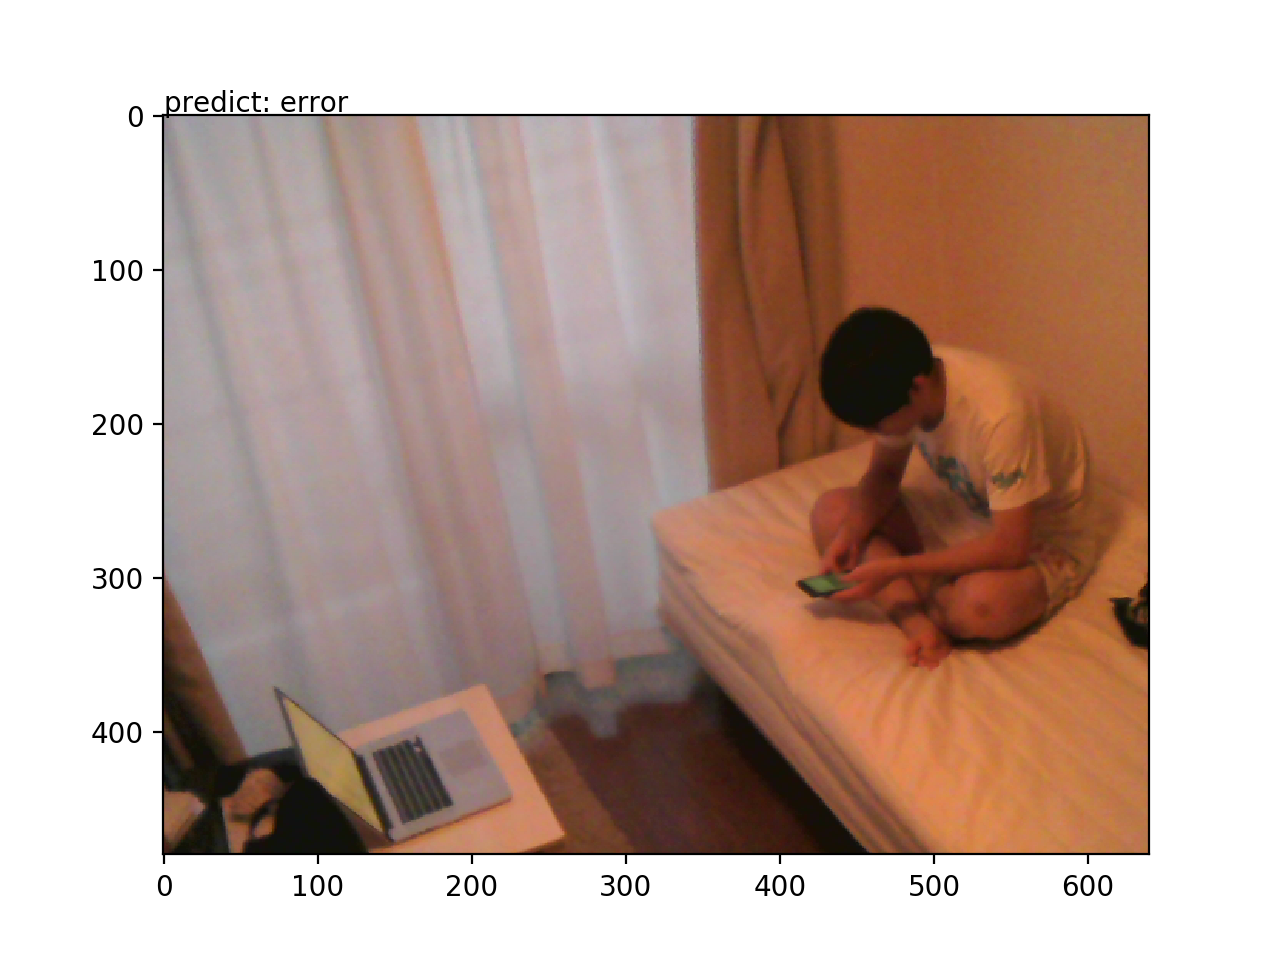

In [5]:
# ロジスティック回帰モデルの評価実験時動画
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 評価実験時データ
images = mongo.images.find({'time': {"$gt": 1505547321.9468176, "$lt": 1505547424.79553}},
                        sort=[("_id", pymongo.ASCENDING)])
fig = plt.figure()

ims = []
for im in images:
    im_path = app.config['RAW_IMG_DIR'] + im['filename']
    img = np.array(Image.open(im_path, 'r'))
    if 'logistic_predict' in im:
        text = plt.text(0, 1.0, "predict: "+ im['logistic_predict'] ,horizontalalignment='left',verticalalignment='bottom')
        img = visualize(im)
        ims.append([plt.imshow(img), text])
    else:
        ims.append([plt.imshow(img)])

ani = animation.ArtistAnimation(fig, ims, interval=500)
# ani.save('vis.mp4', writer="ffmpeg")
plt.show()

In [7]:
# ロジスティック回帰の学習

In [4]:
def reset_data():
    # 学習用データ
    images = mongo.images.find({'time': {"$gt": 1505281469.0253885, "$lt": 1505281856.7716923}},
                        sort=[("_id", pymongo.ASCENDING)])
    global count
    global count_valid 
    count = 0
    count_valid = 0
    features = []
    y = []
    info = []
    for col in images:
        count += 1
        try:
            if len(col['keypoints']['people']) == 1:
                if col['time'] < 1505281584.4140933: # 寝る
                    y.append(0)
                elif col['time'] < 1505281588.009927: # こしかけ
                    y.append(1)
                elif col['time'] < 1505281630.688029: # pc作業 on the bed
                    y.append(2)
                elif col['time'] < 1505281786.5724454: # こしかけ
                    y.append(1)
                else: # 寝る
                    y.append(0)
                    
                features.append(col['keypoints']['people'][0]['pose_keypoints'])
                dict_hoge = {'time': col['time'], 'filename': col['filename']}
                if 'logistic_predict' in col:
                    dict_hoge['predict'] = col['logistic_predict']
                    
                info.append(dict_hoge)
                count_valid += 1
        except:
            continue
        
    global info_array
    info_array = np.asarray(info)
    
    global X
    X = np.array(features)
    pca = PCA(n_components=2)
    global X_2d 
    X_2d = pca.fit_transform(X)
    global Y
    Y = np.array(y)

In [9]:
%matplotlib inline
def print_img(index):
    im_path = app.config['RAW_IMG_DIR'] + info_array[index]['filename']
    img = np.array( Image.open(im_path, 'r') )
    plt.imshow(img)

In [10]:
reset_data()

In [11]:
count_valid

186

In [12]:
count

221

/home/nakamura/.pyenv/versions/anaconda3-4.4.0/envs/detection_server/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


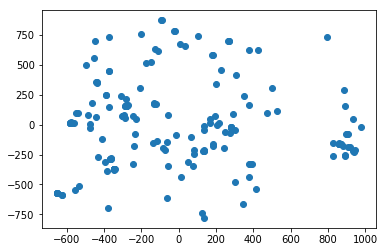

In [13]:
%matplotlib inline
reset_data()
plt.scatter(X_2d[:, 0], X_2d[:, 1])
    
plt.legend()
plt.show()

In [2]:
def set_axL(i):
    if i != 0:
        if Y[i-1] == 0:
                axL.scatter(data[i-1][0], data[i-1][1], color='royalblue')
        elif Y[i-1] == 1:
            axL.scatter(data[i-1][0], data[i-1][1], color='coral')
        elif Y[i-1] == 2:
            axL.scatter(data[i-1][0], data[i-1][1], color='seagreen')
            
    axL.scatter(data[i][0], data[i][1], color='r')
            
    axL.set_title('plot')
    axL.set_xlim(-1000, 1000)
    axL.set_ylim(-800, 1000)
    axL.grid(True)

def set_axR(i):
    im_path = app.config['RAW_IMG_DIR'] + info[i]['filename']
    img = Image.open(im_path, 'r')
    img_arr = np.array(img)
    axR.imshow(img_arr)
    axR.text(0, 1.05, str(i) ,horizontalalignment='left',verticalalignment='bottom', transform=axR.transAxes)
    axR.text(0, 1.0, info[i]['time'] ,horizontalalignment='left',verticalalignment='bottom', transform=axR.transAxes)
    axR.set_title('pic')
    axR.grid(False)

def update_plot(i):
#     axL.clear()
    axR.clear()
    
    set_axL(i)
    set_axR(i)
    
    return axL, axR

<IPython.core.display.Javascript object>


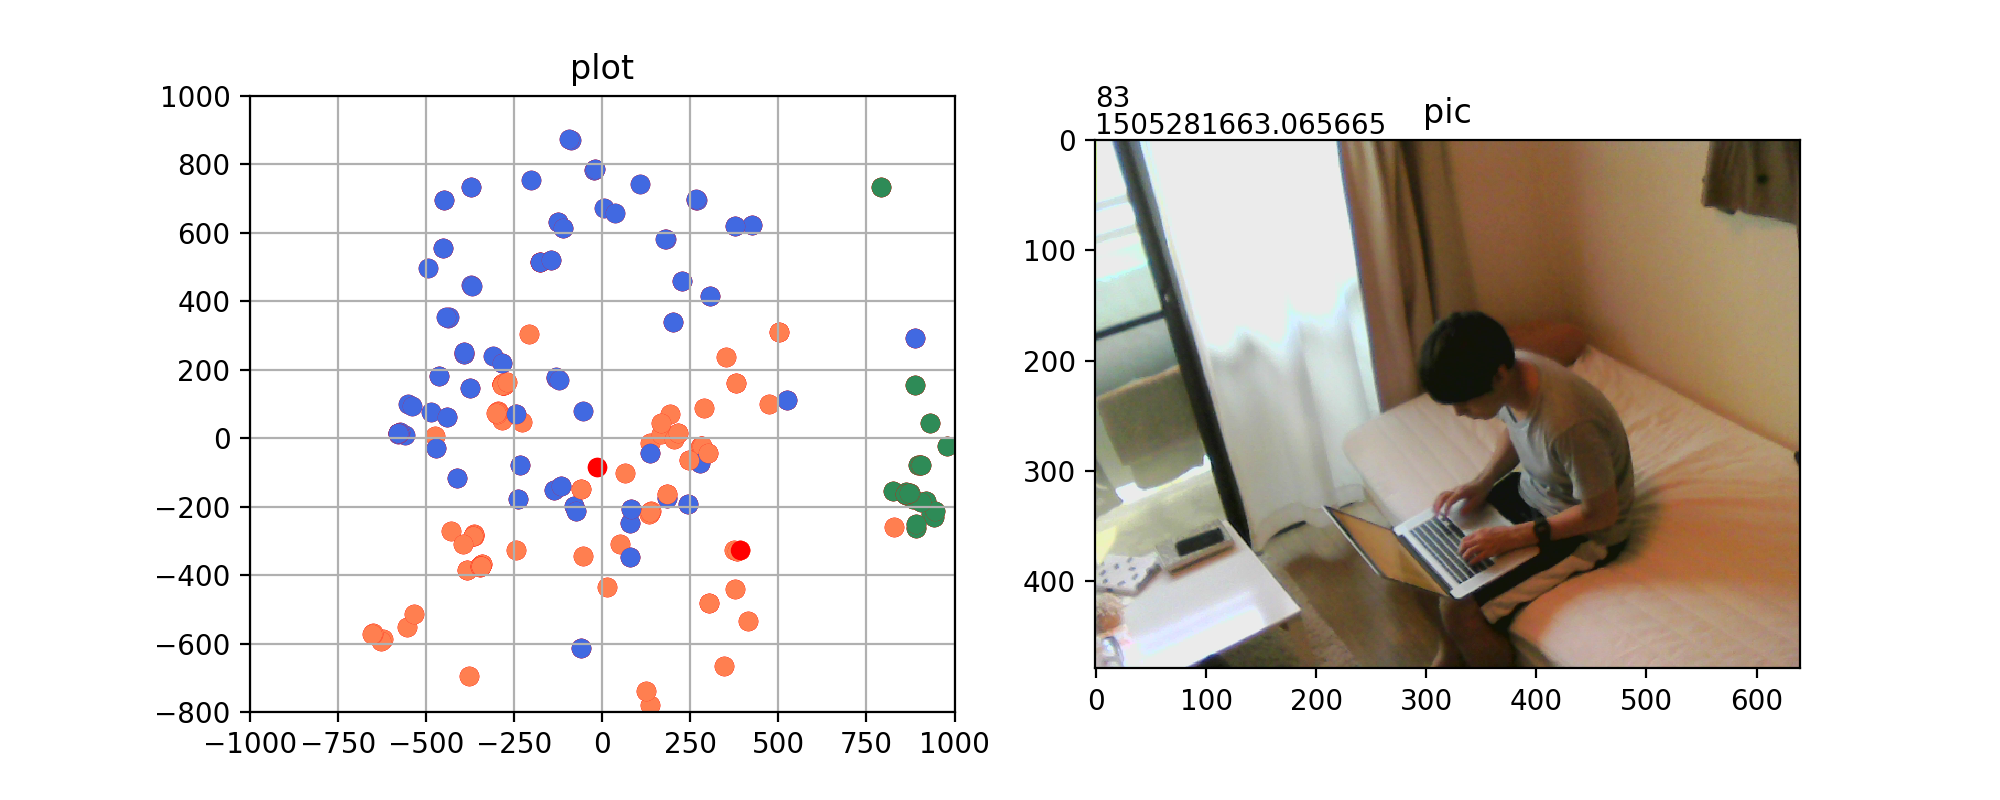

In [5]:
%matplotlib nbagg
reset_data()
data = X_2d.copy()
info = info_array.copy()

# info = info[np.where(data[:, 0] > 550)]
# data = data[np.where(data[:, 0] > 550)]
# info = info[np.where(data[:, 1] < -200)]
# data = data[np.where(data[:, 1] < -200)]

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
ani = animation.FuncAnimation(fig, update_plot, frames=range(len(data)), interval=1000)
# ani.save('result.mp4', writer="ffmpeg")
fig.show()

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, random_state=1)

/home/nakamura/.pyenv/versions/anaconda3-4.4.0/envs/detection_server/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
clf = LogisticRegression()
cross_validation.cross_val_score(clf, X, Y, cv=5)

/home/nakamura/.pyenv/versions/anaconda3-4.4.0/envs/detection_server/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([ 0.94736842,  0.94736842,  0.89473684,  0.81081081,  0.85714286])

In [52]:
from sklearn import metrics
clf.fit(X_train, y_train)
metrics.accuracy_score(clf.predict(X_val), y_val)

0.94736842105263153

In [41]:
from sklearn.externals import joblib
joblib.dump(clf, 'clf.pkl')

['clf.pkl']

In [16]:
# 以下実験時のメモ
# くつろぎ
current_time = time.time()
print(current_time)

1505281469.0253885


In [17]:
# pc作業
current_time = time.time()
print(current_time)

1505281585.1117115


In [18]:
# pc作業 on the bed
current_time = time.time()
print(current_time)

1505281629.752925


In [25]:
# マンガ　 on the bed
current_time = time.time()
print(current_time)

1505281707.9030435


In [26]:
# 寝る 
current_time = time.time()
print(current_time)

1505281784.1729865


In [27]:
# 寝る　with 毛布
current_time = time.time()
print(current_time)

1505281857.4169314


In [28]:
# 終了
current_time = time.time()
print(current_time)

1505281946.08562
